In [21]:
import pandas as pd

def format_seconds(x: float) -> str:
    return r"\SI{" f"{x:0.02f}" r"}{\second}"

fits_df = pd.read_csv("./measure_latency/results/fits.csv")

print(
    pd.DataFrame(fits_df)
    .to_latex(
        index=False,
        formatters={
            "mean": format_seconds,
            "jitter": lambda x: r"$ \pm " + format_seconds(x) + " $",
            "shape": lambda x: r"\num{" f"{x:0.02f}" r"}",
            "scale": format_seconds,
        }
    )
)    

\begin{tabular}{rrrr}
\toprule
mean & jitter & shape & scale \\
\midrule
\SI{0.10}{\second} & $ \pm \SI{0.02}{\second} $ & \num{4.50} & \SI{0.09}{\second} \\
\SI{0.20}{\second} & $ \pm \SI{0.04}{\second} $ & \num{6.26} & \SI{0.18}{\second} \\
\SI{0.40}{\second} & $ \pm \SI{0.08}{\second} $ & \num{6.84} & \SI{0.35}{\second} \\
\SI{0.80}{\second} & $ \pm \SI{0.16}{\second} $ & \num{7.75} & \SI{0.70}{\second} \\
\SI{1.60}{\second} & $ \pm \SI{0.32}{\second} $ & \num{7.69} & \SI{1.39}{\second} \\
\SI{3.20}{\second} & $ \pm \SI{0.64}{\second} $ & \num{7.59} & \SI{2.78}{\second} \\
\bottomrule
\end{tabular}



In [22]:
experiment_cats = pd.CategoricalDtype(["packet", "frame", "step"], ordered=True)

step_frame_data = pd.read_csv('per_frame_step_delay_new_pareto_params.csv')
step_frame_data["model"] = step_frame_data["model"].replace({
    "first-order": "Ref. Stochastic",
    "first-order-median": "Ref. Median",
    "3rd-poly-low": "3rd Order Poly. (low neuroticism)",  # multi-curve always fits 3rd
    "3rd-poly-high": "3rd Order Poly. (high neuroticism)",
    "legacy": "Legacy EdgeDroid 1.0"
}).astype("category")
step_frame_data["mean/jitter"] = step_frame_data[["latency_mean", "latency_jitter"]].apply(lambda row: r"$ " f"{row.latency_mean:01.2f}" r" \pm " f"{row.latency_jitter:01.2f}" r" $", axis=1)
for col in ["latency_rho", "latency_mean", "latency_jitter", "pareto_shape", "pareto_scale", "mean/jitter"]:
    step_frame_data[col] = step_frame_data[col].astype(pd.CategoricalDtype(sorted(step_frame_data[col].unique()), ordered=True))
    
step_frame_data["experiment"] = step_frame_data["experiment"].astype(experiment_cats)

step_frame_data["task_duration"] = step_frame_data.groupby([
    "experiment", "model", "latency_rho", "mean/jitter", 
    "latency_mean", "latency_jitter", "pareto_shape", "pareto_scale", 
    "rep"], observed=True)["step_duration"].cumsum()
step_frame_data.groupby(["experiment", "model", "latency_rho", "mean/jitter", "pareto_scale", "pareto_scale"], observed=True).count()

step_number  \
experiment model                              latency_rho mean/jitter       pareto_scale pareto_scale                
frame      3rd Order Poly. (high neuroticism) 0.0         $ 0.10 \pm 0.02 $ 0.088346     0.088346             1530   
                                                          $ 0.20 \pm 0.04 $ 0.177206     0.177206             1530   
                                                          $ 0.40 \pm 0.08 $ 0.351322     0.351322             1530   
                                                          $ 0.80 \pm 0.16 $ 0.701636     0.701636             1530   
                                                          $ 1.60 \pm 0.32 $ 1.394286     1.394286             1530   
...                                                                                                            ...   
step       Ref. Stochastic                    0.5         $ 0.20 \pm 0.04 $ 0.177206     0.177206             1530   
                                                          $ 0.40 \pm 0.08 $ 0.351322     0.351322             1530   
                                                          $ 0.80 \pm 0.16 $ 0.701636     0.701636             1530   
                                                          $ 1.60 \pm 0.32 $ 1.394286     1.394286             1530   
                                                          $ 3.20 \pm 0.64 $ 2.783705     2.783705             1530   

                                                                                                       last_frame_rtt  \
experiment model                              latency_rho mean/jitter       pareto_scale pareto_scale                   
frame      3rd Order Poly. (high neuroticism) 0.0         $ 0.10 \pm 0.02 $ 0.088346     0.088346                1530   
                                                          $ 0.20 \pm 0.04 $ 0.177206     0.177206                1530   
                                                          $ 0.40 \pm 0.08 $ 0.351322     0.351322                1530   
                                                          $ 0.80 \pm 0.16 $ 0.701636     0.701636                1530   
                                                          $ 1.60 \pm 0.32 $ 1.394286     1.394286                1530   
...                                                                                                               ...   
step       Ref. Stochastic                    0.5         $ 0.20 \pm 0.04 $ 0.177206     0.177206                1530   
                                                          $ 0.40 \pm 0.08 $ 0.351322     0.351322                1530   
                                                          $ 0.80 \pm 0.16 $ 0.701636     0.701636                1530   
                                                          $ 1.60 \pm 0.32 $ 1.394286     1.394286                1530   
                                                          $ 3.20 \pm 0.64 $ 2.783705     2.783705                1530   

                                                                                                       execution_time  \
experiment model                              latency_rho mean/jitter       pareto_scale pareto_scale                   
frame      3rd Order Poly. (high neuroticism) 0.0         $ 0.10 \pm 0.02 $ 0.088346     0.088346                1530   
                                                          $ 0.20 \pm 0.04 $ 0.177206     0.177206                1530   
                                                          $ 0.40 \pm 0.08 $ 0.351322     0.351322                1530   
                                                          $ 0.80 \pm 0.16 $ 0.701636     0.701636                1530   
                                                          $ 1.60 \pm 0.32 $ 1.394286     1.394286                1530   
...                                                                                                               ...   
step       Ref. Stochastic

In [23]:
packet_data = pd.read_csv('./per_packet_delay.csv').drop(columns=["lat_var"])
packet_data[["latency_mean", "latency_jitter"]] = packet_data[["one_way_latency", "one_way_variance"]] * 2 / 1000.0
packet_data["latency_rho"] = packet_data["one_way_corr"] / 100.0
packet_data["mean/jitter"] = packet_data[["latency_mean", "latency_jitter"]].apply(lambda row: r"$ " f"{row.latency_mean:01.2f}" r" \pm " f"{row.latency_jitter:01.2f}" r" $", axis=1)
packet_data["experiment"] = "packet"

for col in ["latency_rho", "mean/jitter", "latency_mean", "latency_jitter"]:
    packet_data[col] = packet_data[col].astype(pd.CategoricalDtype(sorted(step_frame_data[col].unique()), ordered=True))
packet_data["experiment"] = packet_data["experiment"].astype(experiment_cats)
packet_data["model"] = packet_data["model"].astype("category")

# packet_data["mean/var"] = 
packet_data = packet_data[[
    "experiment", "model", "latency_rho", "latency_mean", "latency_jitter", "mean/jitter", "rep",
    "step_number", "execution_time", "step_duration", "time_to_feedback", "wait_time", "frame_count", "task_duration",
]]
packet_data

,experiment,model,latency_rho,latency_mean,latency_jitter,mean/jitter,rep,step_number,execution_time,step_duration,time_to_feedback,wait_time,frame_count,task_duration
0,packet,Ref. Median,0.0,0.2,0.04,$ 0.20 \pm 0.04 $,6,0,0.000000,1.312022,1.312022,0.001056,1,1.312022
1,packet,Ref. Median,0.0,0.2,0.04,$ 0.20 \pm 0.04 $,6,1,5.230947,5.898414,0.667467,0.047629,19,7.210436
2,packet,Ref. Median,0.0,0.2,0.04,$ 0.20 \pm 0.04 $,6,2,5.230947,6.152435,0.921487,0.244008,13,13.362871
3,packet,Ref. Median,0.0,0.2,0.04,$ 0.20 \pm 0.04 $,6,3,5.230947,5.994312,0.763365,0.171086,11,19.357183
4,packet,Ref. Median,0.0,0.2,0.04,$ 0.20 \pm 0.04 $,6,4,5.230947,6.094443,0.863496,0.278195,13,25.451626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45895,packet,Legacy EdgeDroid 1.0,0.0,0.1,0.02,$ 0.10 \pm 0.02 $,6,46,4.049000,4.595999,0.546999,0.032667,15,215.104562
45896,packet,Legacy EdgeDroid 1.0,0.0,0.1,0.02,$ 0.10 \pm 0.02 $,6,47,4.049000,4.824017,0.775017,0.253439,16,219.928579
45897,packet,Legacy EdgeDroid 1.0,0.0,0.1,0.02,$ 0.10 \pm 0.02 $,6,48,4.049000,4.605951,0.556951,0.057825,16,224.534530
45898,packet,Legacy EdgeDroid 1.0,0.0,0.1,0.02,$ 0.10 \pm 0.02 $,6,49,4.049000,4.713981,0.664981,0.116904,14,229.248511


In [24]:
data = pd.concat([
    step_frame_data,
    packet_data
])
data["experiment"] = data["experiment"].astype(pd.CategoricalDtype(["packet", "frame", "step"], ordered=True))
data.groupby(["experiment", "mean/jitter", "latency_rho", "model"], observed=True).count()

step_number  \
experiment mean/jitter       latency_rho model                                             
packet     $ 0.10 \pm 0.02 $ 0.0         3rd Order Poly. (high neuroticism)          510   
                                         3rd Order Poly. (low neuroticism)           510   
                                         Legacy EdgeDroid 1.0                        510   
                                         Ref. Median                                 510   
                                         Ref. Stochastic                             510   
...                                                                                  ...   
step       $ 3.20 \pm 0.64 $ 0.5         3rd Order Poly. (high neuroticism)         1530   
                                         3rd Order Poly. (low neuroticism)          1530   
                                         Legacy EdgeDroid 1.0                       1530   
                                         Ref. Median                                1530   
                                         Ref. Stochastic                            1530   

                                                                             last_frame_rtt  \
experiment mean/jitter       latency_rho model                                                
packet     $ 0.10 \pm 0.02 $ 0.0         3rd Order Poly. (high neuroticism)               0   
                                         3rd Order Poly. (low neuroticism)                0   
                                         Legacy EdgeDroid 1.0                             0   
                                         Ref. Median                                      0   
                                         Ref. Stochastic                                  0   
...                                                                                     ...   
step       $ 3.20 \pm 0.64 $ 0.5         3rd Order Poly. (high neuroticism)            1530   
                                         3rd Order Poly. (low neuroticism)             1530   
                                         Legacy EdgeDroid 1.0                          1530   
                                         Ref. Median                                   1530   
                                         Ref. Stochastic                               1530   

                                                                             execution_time  \
experiment mean/jitter       latency_rho model                                                
packet     $ 0.10 \pm 0.02 $ 0.0         3rd Order Poly. (high neuroticism)             510   
                                         3rd Order Poly. (low neuroticism)              510   
                                         Legacy EdgeDroid 1.0                           510   
                                         Ref. Median                                    510   
                                         Ref. Stochastic                                510   
...                                                                                     ...   
step       $ 3.20 \pm 0.64 $ 0.5         3rd Order Poly. (high neuroticism)            1530   
                                         3rd Order Poly. (low neuroticism)             1530   
                                         Legacy EdgeDroid 1.0                          1530   
                                         Ref. Median                                   1530   
                                         Ref. Stochastic                               1530   

                                                                             step_duration  \
experiment mean/jitter       latency_rho model                                               
packet     $ 0.10 \pm 0.02 $ 0.0         3rd Order Poly. (high neuroticism)            510   
                                         3rd Order Poly. (low neuroticism)             510   
                                

In [25]:
task_duration_data = data.groupby(["experiment", "model", "mean/jitter", "latency_rho", "latency_mean", "latency_jitter", "rep"], observed=True)["step_duration"].sum().reset_index()
task_duration_data = task_duration_data.rename(columns={"step_duration": "task_duration"})
task_duration_data

,experiment,model,mean/jitter,latency_rho,latency_mean,latency_jitter,rep,task_duration
0,packet,3rd Order Poly. (high neuroticism),$ 0.10 \pm 0.02 $,0.0,0.1,0.02,1,243.980895
1,packet,3rd Order Poly. (high neuroticism),$ 0.10 \pm 0.02 $,0.0,0.1,0.02,2,242.539840
2,packet,3rd Order Poly. (high neuroticism),$ 0.10 \pm 0.02 $,0.0,0.1,0.02,3,243.138212
3,packet,3rd Order Poly. (high neuroticism),$ 0.10 \pm 0.02 $,0.0,0.1,0.02,4,243.914802
4,packet,3rd Order Poly. (high neuroticism),$ 0.10 \pm 0.02 $,0.0,0.1,0.02,5,250.584355
...,...,...,...,...,...,...,...,...
6295,step,Ref. Stochastic,$ 3.20 \pm 0.64 $,0.5,3.2,0.64,25,544.348120
6296,step,Ref. Stochastic,$ 3.20 \pm 0.64 $,0.5,3.2,0.64,26,572.915995
6297,step,Ref. Stochastic,$ 3.20 \pm 0.64 $,0.5,3.2,0.64,27,520.281830
6298,step,Ref. Stochastic,$ 3.20 \pm 0.64 $,0.5,3.2,0.64,28,507.867364


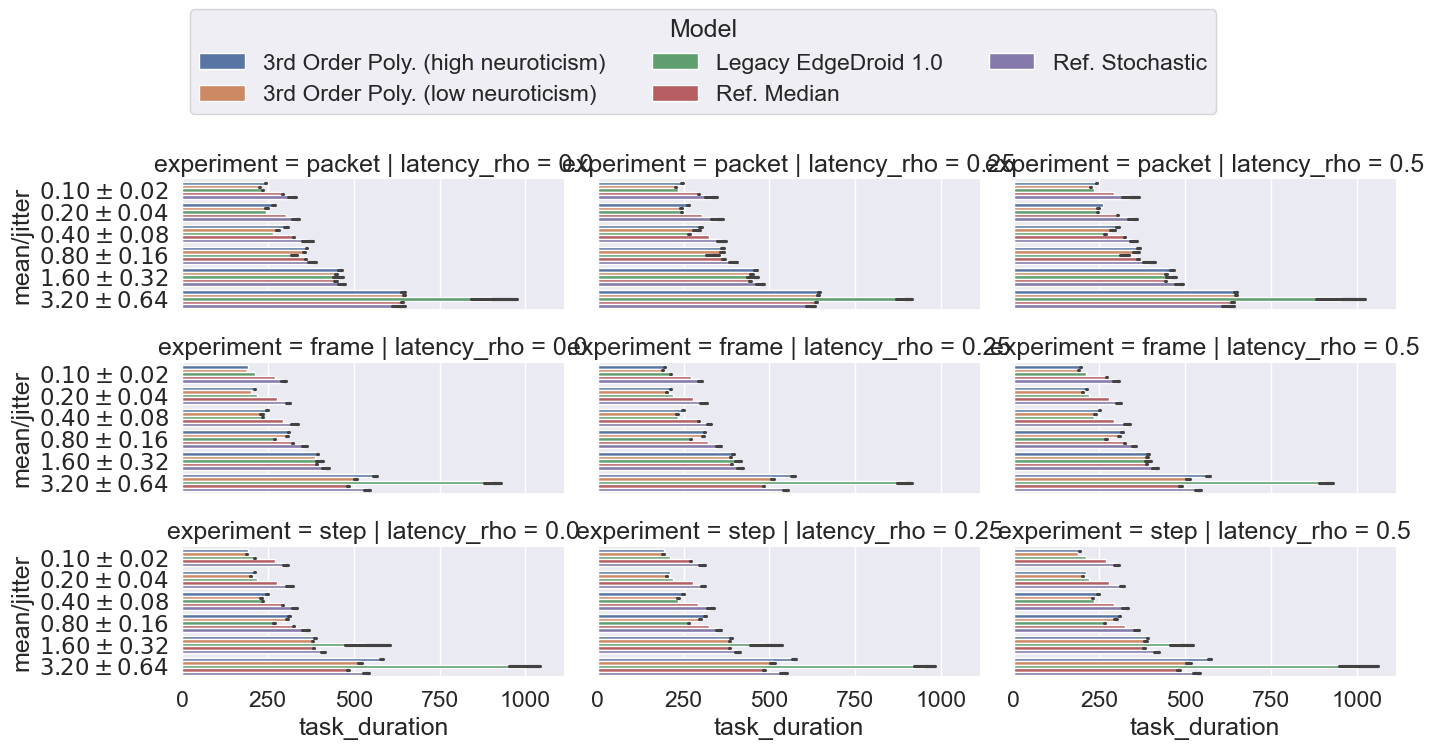

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

FULL_PAGE_WIDTH = 7.2

sns.set_context("paper")
sns.set(font_scale=1.5)

fg = sns.catplot(data=task_duration_data, kind="bar", x="task_duration", y="mean/jitter", hue="model", col="latency_rho", row="experiment", legend_out=False)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
#     ax.yaxis.grid(True, which="minor")
#     ax.yaxis.grid(True, which="major")
#     ax.xaxis.grid(True)

sns.move_legend(fg, "upper center", title="Model", bbox_to_anchor=(.5, 1.2), ncols=3)
fg.figure.set_size_inches((2*FULL_PAGE_WIDTH, 2*3.2))
fg.tight_layout()
plt.show()

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_8783/22772237.py:11: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  fg = sns.catplot(data=comp_data, kind="bar", x="mean/jitter", y="task_duration", hue="model", col="experiment", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)


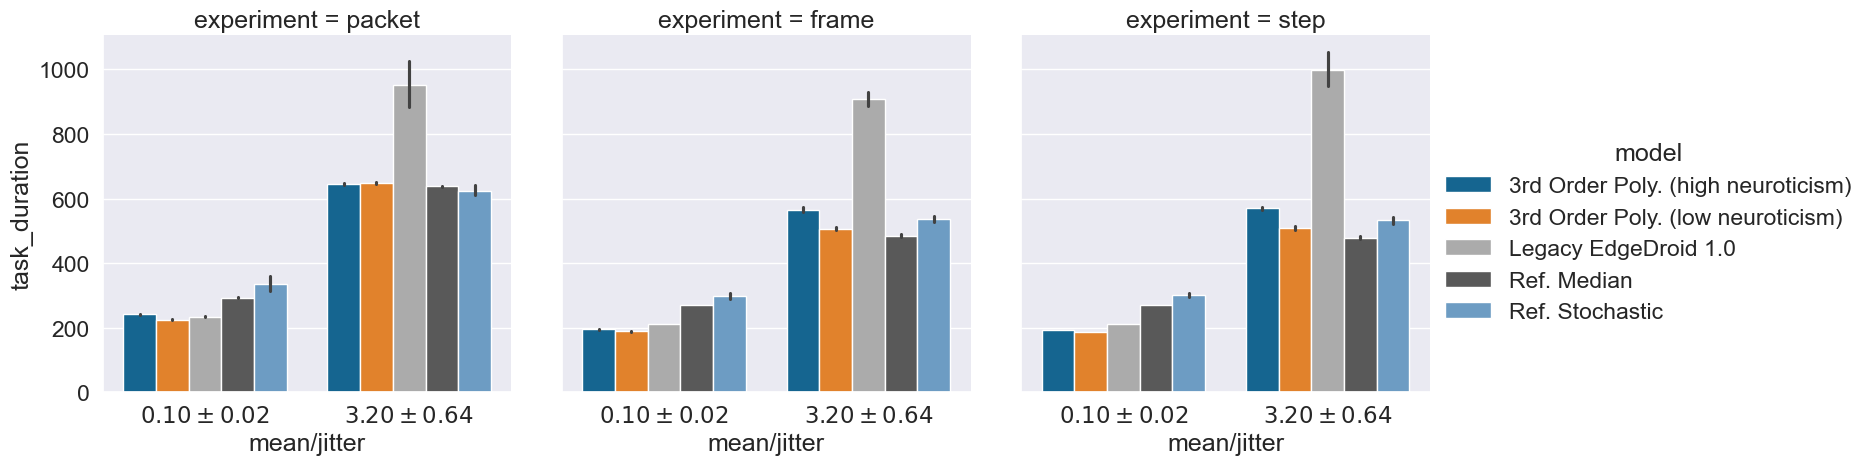

In [27]:
import numpy as np
from pypalettes import load_cmap

comp_data = task_duration_data[
    (task_duration_data.latency_rho == 0.5) 
    & np.isin(task_duration_data.latency_mean, (0.10, 3.20))
    & np.isin(task_duration_data.latency_jitter, (0.02, 0.64))
].copy()
comp_data["mean/jitter"] = comp_data["mean/jitter"].cat.remove_unused_categories()

fg = sns.catplot(data=comp_data, kind="bar", x="mean/jitter", y="task_duration", hue="model", col="experiment", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)
plt.show()



/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_8783/2355337130.py:1: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  fg = sns.catplot(data=comp_data, kind="bar", x="latency_rho", y="task_duration", hue="model", col="experiment", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)


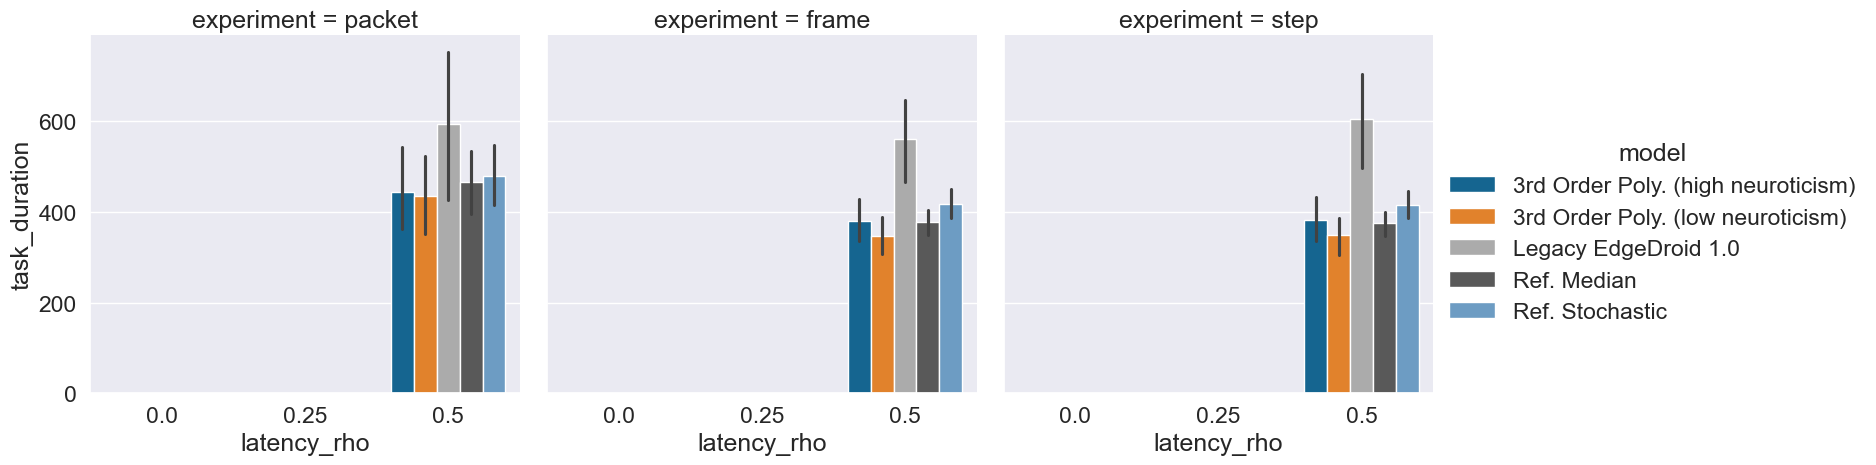

In [28]:
fg = sns.catplot(data=comp_data, kind="bar", x="latency_rho", y="task_duration", hue="model", col="experiment", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)
plt.show()

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_8783/887749227.py:6: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  fg = sns.catplot(data=comp_data, kind="bar", x="latency_rho", y="task_duration", hue="model", col="experiment", row="mean/jitter", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)


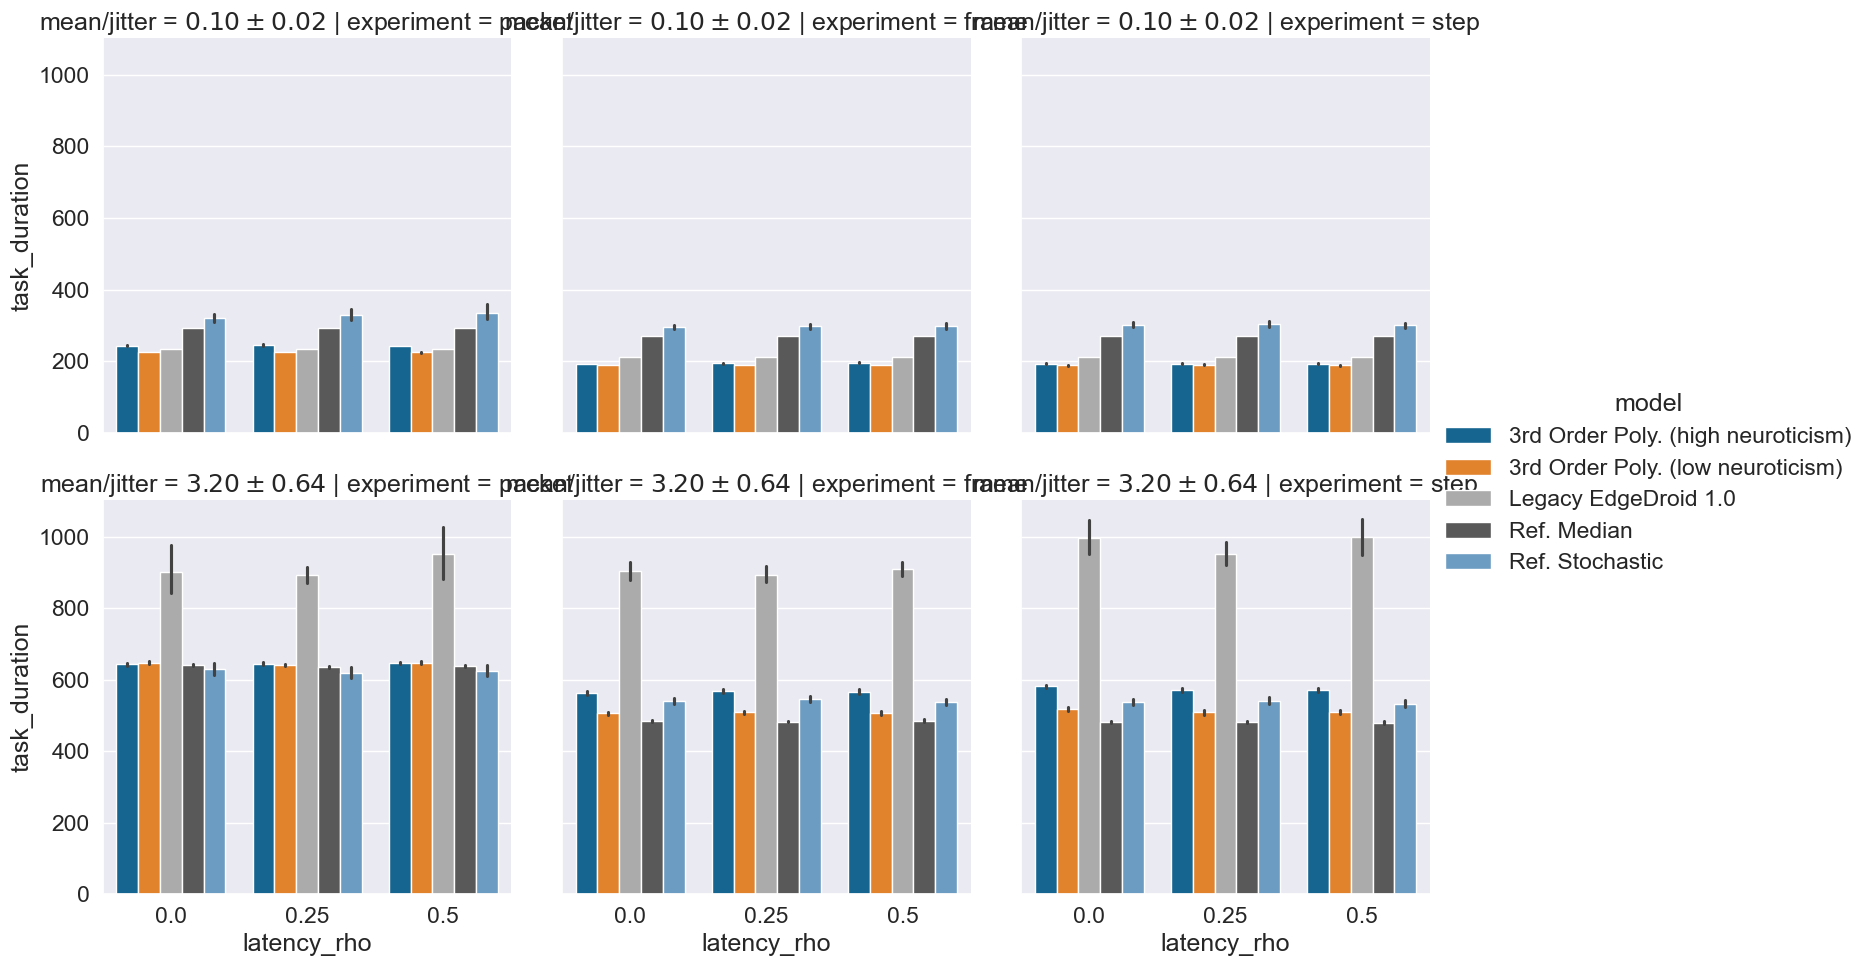

In [29]:
comp_data = task_duration_data[
            np.isin(task_duration_data.latency_mean, (0.10, 3.20))
            & np.isin(task_duration_data.latency_jitter, (0.02, 0.64))].copy()
comp_data["mean/jitter"] = comp_data["mean/jitter"].cat.remove_unused_categories()

fg = sns.catplot(data=comp_data, kind="bar", x="latency_rho", y="task_duration", hue="model", col="experiment", row="mean/jitter", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)
plt.show()

# Paper plots

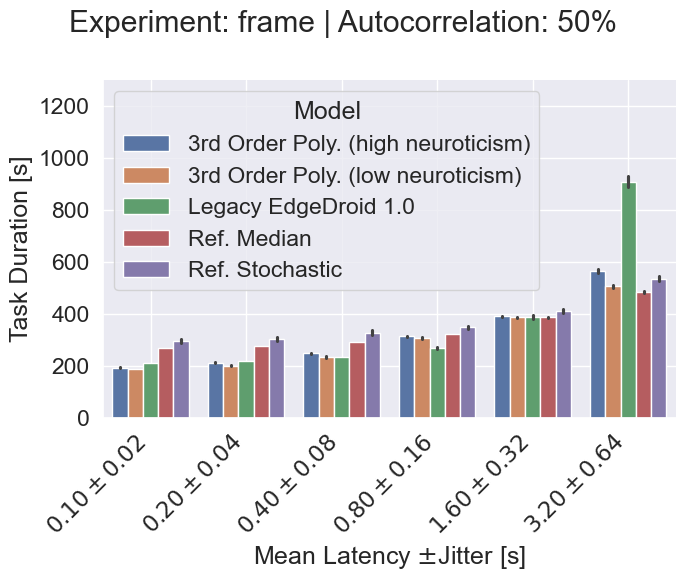

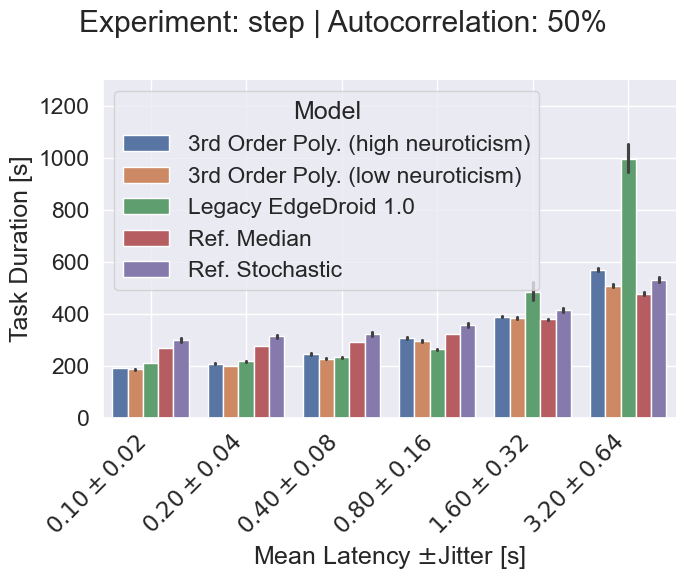

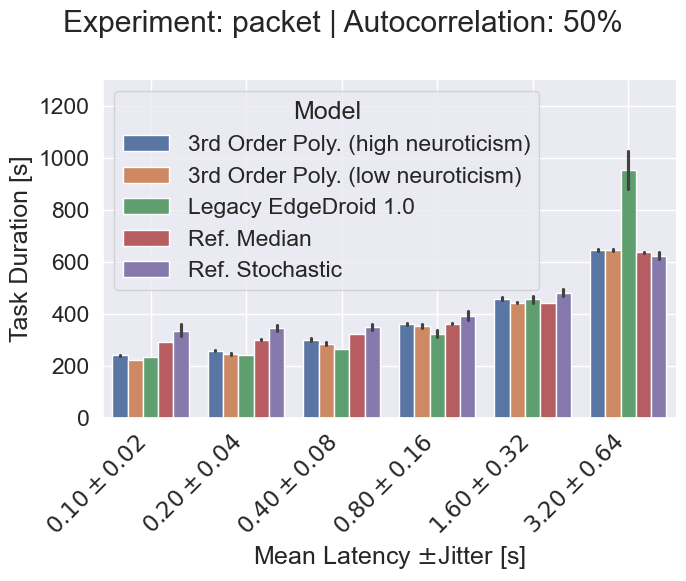

In [31]:
y_axis_max = 1300

for experiment in data.experiment.unique():
    fg = sns.catplot(
        data=task_duration_data[
            (task_duration_data["latency_rho"] == 0.5) & (task_duration_data["experiment"] == experiment)
        ], 
        kind="bar", 
        x="mean/jitter", 
        y="task_duration", 
        hue="model",
        legend_out=False,
        dodge=True,
    )
    for ax in fg.axes.flat:
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        ax.yaxis.grid(True, which="minor")
        ax.yaxis.grid(True, which="major")
        ax.xaxis.grid(True)
    
    fg.set(ylim=(None, y_axis_max))
    fg.set_axis_labels(r"Mean Latency $ \pm $Jitter [s]", "Task Duration [s]")
    fg.legend.set_title("Model")
    fg.fig.set_size_inches(2*FULL_PAGE_WIDTH/2, 6)
    fg.fig.suptitle(f"Experiment: {experiment} | Autocorrelation: 50%")
    fg.fig.tight_layout()
    plt.show()

In [40]:
def cross_difference_durations(df: pd.DataFrame) -> pd.DataFrame:
    realistic_df = df[np.isin(df["model"], ["3rd Order Poly. (low neuroticism)", "3rd Order Poly. (high neuroticism)"])].copy()
    reference_df = df[~np.isin(df["model"], ["3rd Order Poly. (low neuroticism)", "3rd Order Poly. (high neuroticism)"])].copy()
    
    cross_df = pd.merge(
        reference_df[["model", "task_duration"]],
        realistic_df[["model", "task_duration"]],
        suffixes=("_reference", "_realistic"),
        how="cross",
    )
    cross_df["task_duration_reldiff"] = (cross_df["task_duration_reference"] - cross_df["task_duration_realistic"]) / cross_df["task_duration_realistic"]
    return cross_df[["model_reference", "model_realistic", "task_duration_reldiff"]]
    
    
    
reldiff_data = task_duration_data.groupby(["experiment", "latency_mean", "latency_jitter", "mean/jitter", "latency_rho"], observed=True).apply(cross_difference_durations, include_groups=False).reset_index().drop(columns=["level_5"])
reldiff_data["label"] = reldiff_data[["model_reference", "model_realistic"]].apply(lambda row: f"{row.model_reference} | {'High Neuroticism' if 'high' in row.model_realistic else 'Low Neuroticism'}", axis=1)
reldiff_data

,experiment,latency_mean,latency_jitter,mean/jitter,latency_rho,model_reference,model_realistic,task_duration_reldiff,label
0,packet,0.1,0.02,$ 0.10 \pm 0.02 $,0.0,Legacy EdgeDroid 1.0,3rd Order Poly. (high neuroticism),-0.025626,Legacy EdgeDroid 1.0 | High Neuroticism
1,packet,0.1,0.02,$ 0.10 \pm 0.02 $,0.0,Legacy EdgeDroid 1.0,3rd Order Poly. (high neuroticism),-0.019837,Legacy EdgeDroid 1.0 | High Neuroticism
2,packet,0.1,0.02,$ 0.10 \pm 0.02 $,0.0,Legacy EdgeDroid 1.0,3rd Order Poly. (high neuroticism),-0.022249,Legacy EdgeDroid 1.0 | High Neuroticism
3,packet,0.1,0.02,$ 0.10 \pm 0.02 $,0.0,Legacy EdgeDroid 1.0,3rd Order Poly. (high neuroticism),-0.025362,Legacy EdgeDroid 1.0 | High Neuroticism
4,packet,0.1,0.02,$ 0.10 \pm 0.02 $,0.0,Legacy EdgeDroid 1.0,3rd Order Poly. (high neuroticism),-0.051303,Legacy EdgeDroid 1.0 | High Neuroticism
...,...,...,...,...,...,...,...,...,...
205195,step,3.2,0.64,$ 3.20 \pm 0.64 $,0.5,Ref. Stochastic,3rd Order Poly. (low neuroticism),0.070119,Ref. Stochastic | Low Neuroticism
205196,step,3.2,0.64,$ 3.20 \pm 0.64 $,0.5,Ref. Stochastic,3rd Order Poly. (low neuroticism),0.018700,Ref. Stochastic | Low Neuroticism
205197,step,3.2,0.64,$ 3.20 \pm 0.64 $,0.5,Ref. Stochastic,3rd Order Poly. (low neuroticism),-0.010750,Ref. Stochastic | Low Neuroticism
205198,step,3.2,0.64,$ 3.20 \pm 0.64 $,0.5,Ref. Stochastic,3rd Order Poly. (low neuroticism),0.093278,Ref. Stochastic | Low Neuroticism


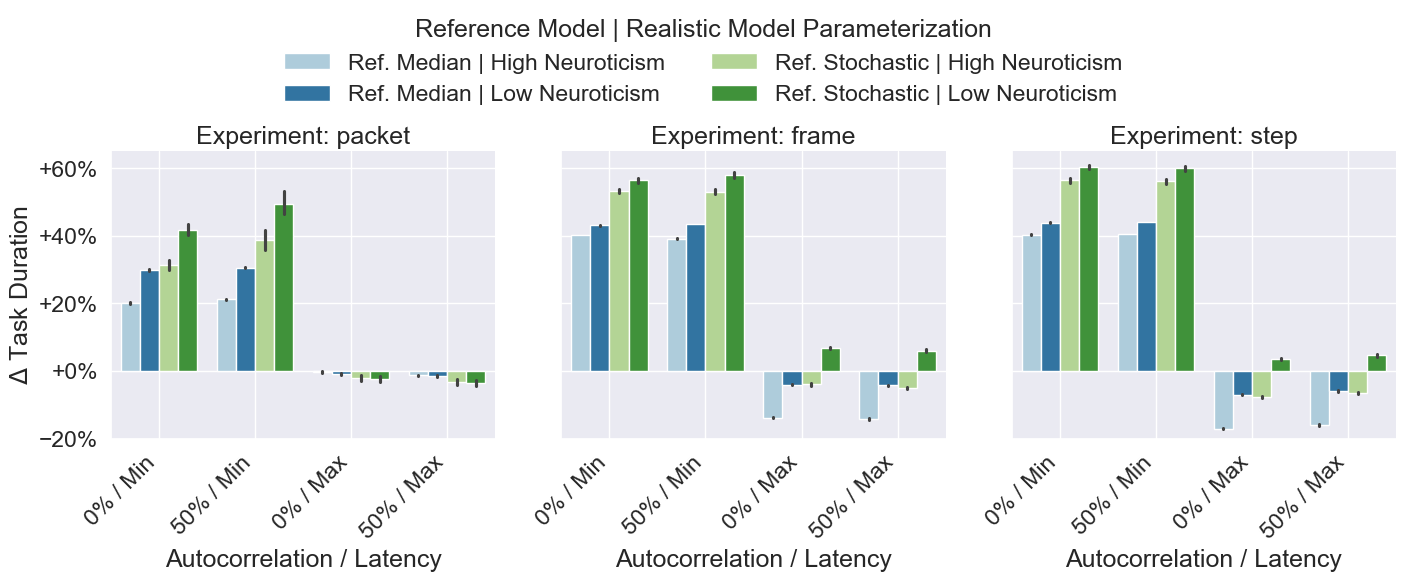

In [42]:
plot_data = reldiff_data[reldiff_data["model_reference"] != "Legacy EdgeDroid 1.0"].copy()
plot_data = plot_data[
    np.isin(plot_data["latency_rho"], (0.0, 0.5))
    & np.isin(plot_data.latency_mean, (0.10, 3.20))
    & np.isin(plot_data.latency_jitter, (0.02, 0.64))
]
for col in ("mean/jitter", "model_reference", "latency_rho"):
    plot_data[col] = plot_data[col].cat.remove_unused_categories()

plot_data["rho_pcnt"] = plot_data["latency_rho"].apply(lambda r: f"{r:.0%}")
plot_data["latency_tag"] = plot_data["mean/jitter"].apply(lambda t: "Min" if "0.10" in t else "Max").astype(pd.CategoricalDtype(("Min", "Max"), ordered=True))
plot_data["rho/latency"] = plot_data[["rho_pcnt", "latency_tag"]].apply(lambda row: " / ".join([str(x) for x in row]), axis=1)

fg = sns.catplot(data=plot_data, kind="bar", hue="label", x="rho/latency", y="task_duration_reldiff", col="experiment", palette="Paired")
for ax in fg.axes.flat:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.yaxis.grid(True, which="minor")
    ax.yaxis.grid(True, which="major")
    ax.xaxis.grid(True)
    ax.yaxis.set_major_formatter("{x:+.0%}")

fg.set_axis_labels(r"Autocorrelation / Latency", r"$ \Delta $ Task Duration")
fg.set(ylim=(-0.2, None))
fg.set_titles(col_template="Experiment: {col_name}")
sns.move_legend(fg, "upper center", title="Reference Model | Realistic Model Parameterization", bbox_to_anchor=(.5, 1.2), ncols=2)
fg.fig.set_size_inches(2*FULL_PAGE_WIDTH, 5)
fg.fig.tight_layout()

plt.show()